In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime



In [2]:
df1 = pd.read_csv('GE.csv')
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,151.776489,152.591202,150.482529,151.872345,137.021820,6708382
1,2017-01-04,152.159882,152.543289,151.536865,151.920258,137.065033,4474320
2,2017-01-05,151.297241,152.159882,150.051208,151.057632,136.286713,5395334
3,2017-01-06,151.345169,152.255737,150.290833,151.488953,136.675903,4615772
4,2017-01-09,151.632721,151.728561,150.626312,150.770081,136.027328,4436678


In [3]:
df1.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
1876,2024-06-18,163.399994,165.190002,162.360001,164.970001,164.970001,5105300
1877,2024-06-20,164.970001,166.300003,163.050003,165.000000,165.000000,4957200
1878,2024-06-21,164.500000,164.919998,161.300003,164.240005,164.240005,17195200


In [4]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df1['Date'])
print(train_dates.head()) #Check last few dates. 

df1['Years'] = pd.to_datetime(df1['Date']).dt.year


0   2017-01-03
1   2017-01-04
2   2017-01-05
3   2017-01-06
4   2017-01-09
Name: Date, dtype: datetime64[ns]


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879 entries, 0 to 1878
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1879 non-null   object 
 1   Open       1879 non-null   float64
 2   High       1879 non-null   float64
 3   Low        1879 non-null   float64
 4   Close      1879 non-null   float64
 5   Adj Close  1879 non-null   float64
 6   Volume     1879 non-null   int64  
 7   Years      1879 non-null   int32  
dtypes: float64(5), int32(1), int64(1), object(1)
memory usage: 110.2+ KB


In [6]:
# plt.figure(figsize=(12, 8))
# for i in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
#     plt.plot(df1['Date'],df1[i],label=i)

# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Prices Over Time')
# plt.legend()
# plt.show()

In [7]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import matplotlib.dates as mdates

# df1 = df1.sort_values('Date')

# # Plot each column
# plt.figure(figsize=(12, 8))
# for column in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
#     plt.plot(df1['Date'], df1[column], label=column)

# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Prices Over Time')
# plt.legend()

# # Improve date formatting
# plt.gcf().autofmt_xdate()

# # Set major ticks format
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

# plt.show()


# plt.show()


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879 entries, 0 to 1878
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1879 non-null   object 
 1   Open       1879 non-null   float64
 2   High       1879 non-null   float64
 3   Low        1879 non-null   float64
 4   Close      1879 non-null   float64
 5   Adj Close  1879 non-null   float64
 6   Volume     1879 non-null   int64  
 7   Years      1879 non-null   int32  
dtypes: float64(5), int32(1), int64(1), object(1)
memory usage: 110.2+ KB


In [9]:
df1.describe()

,Open,High,Low,Close,Adj Close,Volume,Years
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1.879000e+03,1879.000000
mean,71.971566,72.842632,71.066423,71.944726,69.728389,1.297076e+07,2020.251730
std,33.205392,33.352117,33.031794,33.218382,31.226139,8.648125e+06,2.165409
min,27.960997,28.210203,27.313059,27.362900,26.821478,1.981995e+06,2017.000000
25%,48.925512,49.891190,48.232288,48.946840,48.187868,7.416082e+06,2018.000000
50%,62.876778,63.697243,62.205837,62.936951,61.529762,1.061757e+07,2020.000000
75%,86.711891,87.597771,85.682365,86.739823,84.512661,1.561480e+07,2022.000000
max,168.759995,170.800003,168.100006,168.860001,168.860001,8.046506e+07,2024.000000


1. The standard deviations for all price columns are around 28-29, suggesting a moderate level of price fluctuation. The volume's standard deviation is quite high, showing significant variability in trading activity.

In [10]:
# selecting the columns for input data - X  
cols_select = list(df1)[1:6]
cols_select

['Open', 'High', 'Low', 'Close', 'Adj Close']

Generating data for training 

In [11]:
df_training = df1[cols_select].astype(float)
df_training.head(2)

,Open,High,Low,Close,Adj Close
0,151.776489,152.591202,150.482529,151.872345,137.021820
1,152.159882,152.543289,151.536865,151.920258,137.065033


# Data Pre-processing 

## Training the data on LSTM
#### LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be scale the data 
#### scaling the dataset

In [12]:
df_training.shape

(1879, 5)

In [13]:
scaler = StandardScaler()
scaler = scaler.fit(df_training)
# scaled dataset
df_for_training_scaled = scaler.transform(df_training)
df_for_training_scaled

array([[2.40401224, 2.39174619, 2.40487234, 2.40676668, 2.15560894],
       [2.41556142, 2.39030923, 2.43679966, 2.40820943, 2.15699319],
       [2.38957556, 2.37881043, 2.39181111, 2.38223419, 2.13206128],
       ...,
       [2.75415415, 2.76959788, 2.76454502, 2.80116105, 3.05087239],
       [2.80144842, 2.80288801, 2.78543961, 2.80206437, 3.05183335],
       [2.7872903 , 2.76150016, 2.73244625, 2.77917953, 3.02748845]])

## Data Splitting
### Applying Time based Splitting:
Split the data into train, cross-validation, and test sets

In [14]:
n_total = len(df_for_training_scaled)
n_total

1879

In [15]:
train_size = int(n_total * 0.7)                             
test_size = n_total - train_size
print(f"Train size:{train_size}, Test Size:{test_size}")

Train size:1315, Test Size:564


In [16]:
# # Creating splitted data
train_data = df_for_training_scaled[:train_size]
test_data = df_for_training_scaled[train_size:]

In [17]:
train_data.shape

(1315, 5)

1. As required for LSTM networks, we require to reshape an input data into (n_samples x timesteps x n_features). 
2. In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

In [18]:
n_future = 1   # n_timesteps - Number of days we want to look into the future based on the past days.
n_past = 14  # n_samples - Number of past days we want to use to predict the future.

Reformat input data into a shape: (n_samples x timesteps x n_features)

In my example, my df_for_training_scaled has a shape (1879, 5)

1879 refers to the number of data points and 5 refers to the columns (multi-variables).

Know defining the input(x) and output(y) columns for training, validation and testing.

In [19]:
df_for_training_scaled.shape

(1879, 5)

In [20]:
def createData(df):
    X,y=[],[]
    for i in range(n_past,len(df)-n_future+1):
        X.append(df[i-n_past:i , 0:df.shape[1]])
        y.append(df[i+n_future-1 : n_future + i,0])
    return np.array(X),np.array(y)


In [21]:
trainX,trainY = createData(train_data)
testX,testY = createData(test_data)

#### Finally out test , validation and training data has been generated

In [22]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1301, 14, 5).
trainY shape == (1301, 1).
testX shape == (550, 14, 5).
testY shape == (550, 1).


In [23]:
trainY

array([[ 2.14271054],
       [ 2.22355559],
       [ 2.22644263],
       ...,
       [-0.39545143],
       [-0.3806251 ],
       [-0.39301163]])

In [24]:
trainX

array([[[ 2.40401224,  2.39174619,  2.40487234,  2.40676668,
          2.15560894],
        [ 2.41556142,  2.39030923,  2.43679966,  2.40820943,
          2.15699319],
        [ 2.38957556,  2.37881043,  2.39181111,  2.38223419,
          2.13206128],
        ...,
        [ 2.34337893,  2.31988125,  2.35407887,  2.33749837,
          2.08912498],
        [ 2.27263975,  2.25663986,  2.24523565,  2.23936796,
          1.99494207],
        [ 2.23510474,  2.20058505,  2.14074648,  2.12680699,
          1.88690899]],

       [[ 2.41556142,  2.39030923,  2.43679966,  2.40820943,
          2.15699319],
        [ 2.38957556,  2.37881043,  2.39181111,  2.38223419,
          2.13206128],
        [ 2.39101932,  2.38168523,  2.39906742,  2.39522205,
          2.14452819],
        ...,
        [ 2.27263975,  2.25663986,  2.24523565,  2.23936796,
          1.99494207],
        [ 2.23510474,  2.20058505,  2.14074648,  2.12680699,
          1.88690899],
        [ 2.14271054,  2.13590625,  2.17557605, 

based on the data of consecutive 14 (X) days we have taken output the data (Y) for  open price of stock
the 15th day output is the expected output according to given data.
given in trainY array

In my case, trainX has a shape (1879, 14, 5). 

12809 because we are looking back 14 days (1879 - 14 = 1865). 

Remember that we cannot look back 14 days until we get to the 15th day. 

Also, trainY has a shape (1865, 1). Our model only predicts a single value, but 
it needs multiple variables (5 in my example) to make this prediction. 

This is why we can only predict a single day after our training, the day after where our data ends.

To predict more days in future, we need all the 5 variables which we do not have. 

We need to predict all variables if we want to do that. 

### Applying LSTM Model 

In [25]:
trainX.shape[2]      

5

In [26]:
def create_model():
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(trainY.shape[1])
    ])
    return model

In [27]:
# Initially, for epoch < 30, the learning rate (lr) remains 1e-3 (0.001).
# After epoch >= 30, the learning rate decreases by a factor of 0.1 every 30 epochs. Specifically:

def lr_schedule(epoch):
    return 1e-3 * (0.1 ** int(epoch / 30))

model = create_model()
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='mae', optimizer=optimizer, metrics=['mse'])
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    trainX, trainY,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.4669 - mse: 0.4602 - val_loss: 0.0931 - val_mse: 0.0115 - learning_rate: 0.0010
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0974 - mse: 0.0159 - val_loss: 0.0509 - val_mse: 0.0043 - learning_rate: 0.0010
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0982 - mse: 0.0181 - val_loss: 0.0501 - val_mse: 0.0041 - learning_rate: 0.0010
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0789 - mse: 0.0116 - val_loss: 0.0496 - val_mse: 0.0041 - learning_rate: 0.0010
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0749 - mse: 0.0097 - val_loss: 0.0486 - val_mse: 0.0038 - learning_rate: 0.0010
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0729 - mse: 0.0093 - val_loss: 0.0496 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0791 - mse: 0.0112 - val_loss: 0.0509 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 

### Fiting and Training the model

In [28]:
# history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_data=(testX,testY), verbose=1)


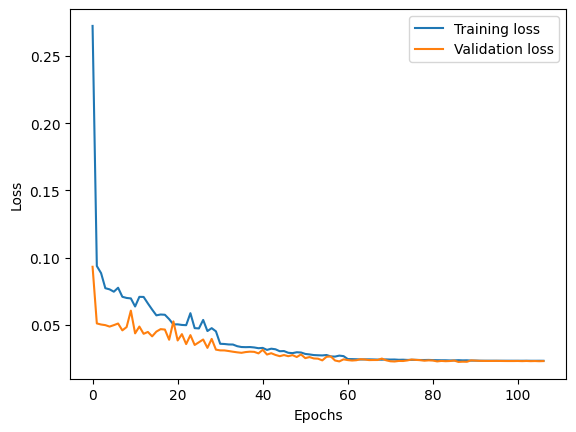

In [29]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1. Overall Trend: Both training and validation losses decrease over time, which is a positive sign indicating that the model is learning.


2. Training Loss (Blue Line): Starts very high (around 16) and decreases rapidly in the first 20 epochs.
Continues to decrease more gradually until about epoch 50.
Stabilizes at a very low value after epoch 50.


3. Validation Loss (Orange Line): Starts lower than the training loss (around 3).
Decreases quickly in the first 10-15 epochs.
Stabilizes much earlier than the training loss, around epoch 20.


4. Convergence: The training and validation losses converge around epoch 50.
After convergence, both losses remain stable and very close to each other.


5. Overfitting: There's no clear sign of overfitting, as the validation loss doesn't increase while the training loss continues to decrease.


6. Model Performance: The model appears to be learning effectively, as both losses decrease and converge.
The final low and stable loss values suggest good performance on both training and validation data.


7. Learning Rate: The rapid initial decrease in loss might indicate an effective learning rate strategy.


8. Potential Early Stopping Point: Around epoch 50-60 could be a good point for early stopping, as the losses have converged and stabilized.

### Making Prediciton

In [30]:
trainX.shape

(1301, 14, 5)

In [31]:
# Make predictions
train_prediction = model.predict(trainX)
test_prediction = model.predict(testX)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [32]:
train_prediction

array([[ 2.1588562 ],
       [ 2.1569152 ],
       [ 2.2347457 ],
       ...,
       [-0.3748108 ],
       [-0.38396853],
       [-0.38296986]], dtype=float32)

In [33]:
print(f'Train Prediciton shape:{train_prediction.shape} , Test Prediciton shape:{test_prediction.shape}')

Train Prediciton shape:(1301, 1) , Test Prediciton shape:(550, 1)


In [34]:
# Inverse transform predictions
pred_train = np.repeat(train_prediction, df_training.shape[1], axis=-1)
y_pred_Train = scaler.inverse_transform(pred_train)[:,0]

pred_test = np.repeat(test_prediction, df_training.shape[1], axis=-1)
y_pred_Test = scaler.inverse_transform(pred_test)[:,0]

In [35]:
print(f'Train Prediciton shape:{pred_train.shape} , Test Prediciton shape:{pred_test.shape}')
print(f'New Train Prediciton shape:{y_pred_Train.shape} , Test Prediciton shape:{y_pred_Test.shape}')

Train Prediciton shape:(1301, 5) , Test Prediciton shape:(550, 5)
New Train Prediciton shape:(1301,) , Test Prediciton shape:(550,)


since earlier shape of original dataset is same<br>
trainX shape == (1301, 14, 5).<br>
trainY shape == (1301, 1).<br>
testX shape == (550, 14, 5).<br>
testY shape == (550, 1).<br>

In [36]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f'MSE of train set:{math.sqrt(mean_squared_error(trainY,y_pred_Train))}')
print(f'MSE of test set:{math.sqrt(mean_squared_error(testY,y_pred_Test))}')

print(f'MAE of train set:{math.sqrt(mean_absolute_error(trainY,y_pred_Train))}')
print(f'MAE of test set:{math.sqrt(mean_absolute_error(testY,y_pred_Test))}')



MSE of train set:73.04298089872384
MSE of test set:89.5514869597163
MAE of train set:8.177996107259048
MAE of test set:9.086980361098934


In [37]:
print(f' Actual:  {df1.Open[15]} actual  {y_pred_Train[0]}')

 Actual:  145.78595 actual  143.63815307617188


Close to real value 

In [38]:
train_size

1315

In [39]:
df_visual1=pd.DataFrame()
df_visual1['date'] = df1.iloc[14:1315,0].values
df_visual1['predicted_price(y^)'] = y_pred_Train
df_visual1['Original(y)'] = df1.iloc[14:1315, 1].values
df_visual1.shape

(1301, 3)

In [40]:
df_visual2=pd.DataFrame()
df_visual2['date'] = df1.iloc[1329:,0].values
df_visual2['predicted_price(y^)'] = y_pred_Test
df_visual2['Original(y)'] = df1.iloc[1329:, 1].values
df_visual2.shape

(550, 3)

In [41]:
# df1[1315:1330]

In [42]:
d = [df_visual1,df_visual2]
result = pd.concat(d)
result.shape

(1851, 3)

In [43]:
result.tail()

,date,predicted_price(y^),Original(y)
545,2024-06-14,158.981384,154.220001
546,2024-06-17,157.465332,156.139999
547,2024-06-18,162.828445,163.399994
548,2024-06-20,164.715744,164.970001
549,2024-06-21,163.360184,164.500000


Differnece between orginal and predicted is in acceptable range

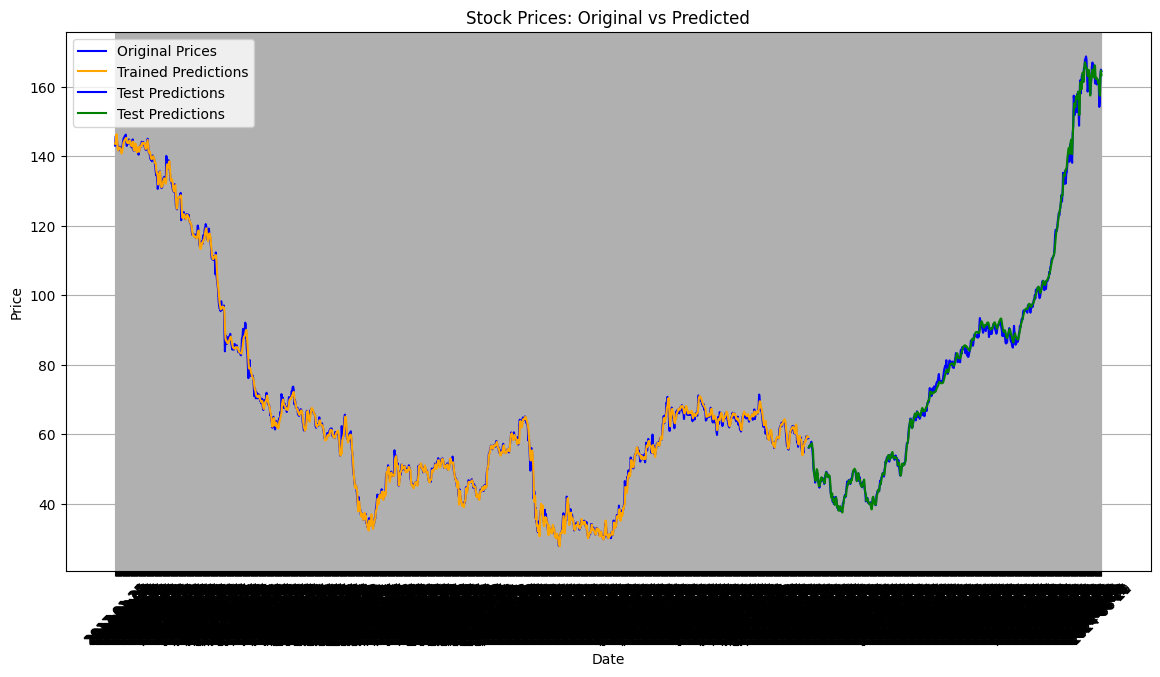

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(df_visual1['date'], df_visual1['Original(y)'], label='Original Prices', color='blue')
plt.plot(df_visual1['date'], df_visual1['predicted_price(y^)'], label='Trained Predictions', color='orange')

plt.plot(df_visual2['date'], df_visual2['Original(y)'], label='Test Predictions', color='blue')
plt.plot(df_visual2['date'], df_visual2['predicted_price(y^)'], label='Test Predictions', color='green')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices: Original vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Future Price predictions

In [45]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [46]:
scaler1 = scaler.fit(df_training)
# scaled dataset
df_for_training_scaled1 = scaler1.transform(df_training)
df_for_training_scaled1

array([[2.40401224, 2.39174619, 2.40487234, 2.40676668, 2.15560894],
       [2.41556142, 2.39030923, 2.43679966, 2.40820943, 2.15699319],
       [2.38957556, 2.37881043, 2.39181111, 2.38223419, 2.13206128],
       ...,
       [2.75415415, 2.76959788, 2.76454502, 2.80116105, 3.05087239],
       [2.80144842, 2.80288801, 2.78543961, 2.80206437, 3.05183335],
       [2.7872903 , 2.76150016, 2.73244625, 2.77917953, 3.02748845]])

In [81]:
trainX1 = []
trainY1 = []
for i in range(n_past, len(df_for_training_scaled1) - n_future + 1):
    trainX1.append(df_for_training_scaled1[i - n_past:i, 0:df_training.shape[1]])
    trainY1.append(df_for_training_scaled1[i + n_future - 1:i + n_future, 0])
    
trainX1, trainY1 = np.array(trainX1), np.array(trainY1)

print('trainX1 shape == {}.'.format(trainX1.shape))
print('trainY1 shape == {}.'.format(trainY1.shape))

trainX1 shape == (1844, 16, 5).
trainY1 shape == (1844, 1).


In [82]:
train_dates = pd.to_datetime(df1['Date'])
train_dates.iloc[-1]

Timestamp('2024-06-21 00:00:00')

In [75]:
trainY.shape

(1301, 1)

In [96]:
n_future = 20
# Forecast period dates
forecast_period_dates = pd.date_range(train_dates.iloc[-1], periods=n_future, freq='1d').tolist()
forecast = model.predict(trainX1[-n_future:])
forecast_copies = np.repeat(forecast, df_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]
y_pred_future

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([158.7118 , 159.15599, 164.01271, 165.82845, 162.96527, 163.01814,
       166.50586, 167.25972, 165.9876 , 164.9894 , 166.21751, 166.76787,
       164.04892, 162.88377, 163.83188, 162.08266, 158.3862 , 157.6735 ,
       161.78944, 164.19856], dtype=float32)

In [97]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open Forecasted':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [98]:
df_forecast

,Date,Open Forecasted
0,2024-06-21,158.711807
1,2024-06-22,159.155991
2,2024-06-23,164.012711
3,2024-06-24,165.828445
4,2024-06-25,162.965271
5,2024-06-26,163.018143
6,2024-06-27,166.505859
7,2024-06-28,167.259720
8,2024-06-29,165.987595
9,2024-06-30,164.989395


In [99]:
original = df1[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2024-5-1']

C:\Users\user\AppData\Local\Temp\ipykernel_15928\2870598733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [ ]:

plt.plot(df_visual2['date'], df_visual2['Original(y)'], label='Test Predictions', color='blue')
plt.plot(df_visual2['date'], df_visual2['predicted_price(y^)'], label='Test Predictions', color='green')


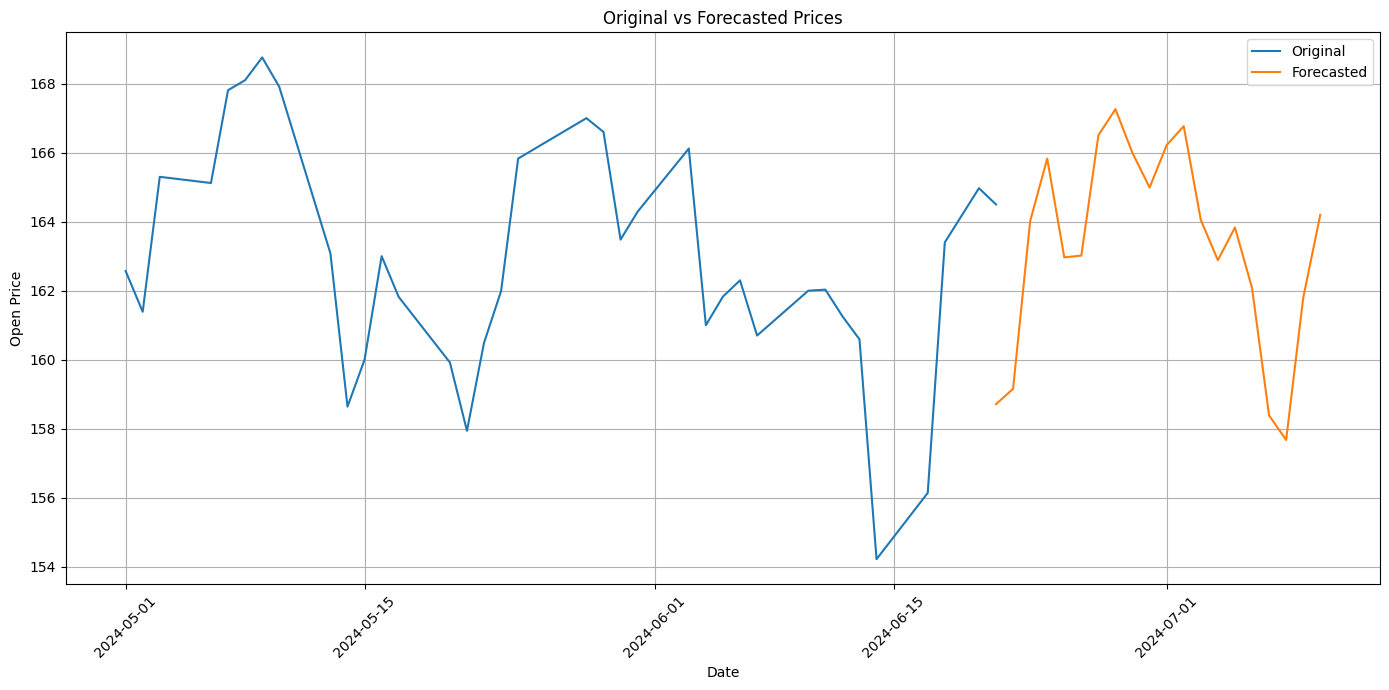

In [100]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=original, x='Date', y='Open', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='Open Forecasted', label='Forecasted')
sns.lineplot(data=df_forecast, x='Date', y='Open Forecasted', label='Forecasted')
sns.lineplot(data=df_forecast, x='Date', y='Open Forecasted', label='Forecasted')

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Original vs Forecasted Prices')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Suggestions 

Certainly! Here are several strategies to potentially improve your model and reduce the gap between predicted and original values:

Feature Engineering:

Add technical indicators (e.g., Moving Averages, RSI, MACD)
Include market sentiment data (e.g., from news headlines or social media)
Incorporate macroeconomic indicators (e.g., interest rates, GDP growth)


Model Architecture:

Experiment with different LSTM architectures (e.g., stacked LSTMs, bidirectional LSTMs)
Try attention mechanisms to help the model focus on relevant parts of the input sequence
Implement a hybrid model combining LSTM with other algorithms (e.g., LSTM-CNN)


Hyperparameter Tuning:

Use techniques like Grid Search, Random Search, or Bayesian Optimization to find optimal hyperparameters
Adjust learning rate, batch size, number of epochs, and network architecture


Ensemble Methods:

Combine predictions from multiple models (e.g., LSTM, Prophet, ARIMA)
Use techniques like bagging or boosting to create ensemble models


Data Preprocessing:

Experiment with different scaling techniques (e.g., Min-Max scaling, Robust scaling)
Try different sequence lengths for input data
Use techniques like SMOTE if dealing with imbalanced data


Regularization:

Implement dropout layers or L1/L2 regularization to prevent overfitting
Use early stopping with a patience parameter


Time-based Features:

Add cyclical time features (e.g., day of week, month of year)
Include holiday indicators


External Data:

Incorporate data from related stocks or market indices
Use company-specific news or earnings reports


Multi-task Learning:

Train the model to predict multiple related values (e.g., open, close, high, low prices)


Differential Learning Rates:

Use different learning rates for different layers of the network


Residual Connections:

Implement skip connections or residual blocks in your network


Data Augmentation:

Create synthetic data points by adding small amounts of noise to existing data


Transfer Learning:

Pre-train your model on a larger dataset and fine-tune on your specific stock


Attention to Outliers:

Identify and handle outliers in your training data


Rolling Forecast Origin:

Implement a rolling forecast origin for model training and evaluation


Prediction Intervals:

Implement techniques to provide prediction intervals, not just point estimates